## **Base** Model: 


In [ ]:
/*author: HRITHIK KANOJE, RISHABH SINGH
Class: CS5330 Pattern Recog & Computer Vision
Prof: Bruce Maxwell
Project 5: Recognition using Deep Networks
*/
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.cm as cm
import numpy as np
import os
import seaborn as sns
sns.set_theme()

In [ ]:
def compute_size(size, kernel_size, stride):
    return (size - kernel_size) // stride + 1


In [ ]:
if not os.path.exists('results'):
    os.makedirs('results')


In [ ]:
class base_model(nn.Module):
    def __init__(self, kernel_num = 10, kernel_size = 5, dropout_rate = 0.5, pool_size = 2, activation_func = F.relu, hidden_nodes = 50, training_epoch = 5, batch_size = 64):
        super(base_model, self).__init__()

        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.pool_size = pool_size
        self.activation_func = activation_func
        self.hidden_nodes = hidden_nodes

        self.fc_input_size = compute_size(28, self.kernel_size, 1)
        self.fc_input_size = compute_size(self.fc_input_size, self.pool_size, self.pool_size)
        self.fc_input_size = compute_size(self.fc_input_size, self.kernel_size, 1)
        self.fc_input_size = compute_size(self.fc_input_size, 2, 2)
        self.fc_input_size = 20 * self.fc_input_size * self.fc_input_size
  

        self.n_epochs = training_epoch
        self.batch_size_train = batch_size
        self.batch_size_test = 1000
        self.learning_rate = 0.01
        self.momentum = 0.5
        self.log_interval = 10
        self.random_seed = 42

        torch.backends.cudnn.enabled = False
        torch.manual_seed(self.random_seed)

        # load the training dataset 
        self.train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True,
                                                        transform=torchvision.transforms.Compose([
                                                            torchvision.transforms.ToTensor(),
                                                            torchvision.transforms.Normalize(
                                                                (0.1307,), (0.3081,))
                                                        ]))
        self.train_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size_train)
      #  load the test dataset
        self.test_dataset = torchvision.datasets.MNIST('../data', train=False, download=True,
                                                       transform=torchvision.transforms.Compose([
                                                           torchvision.transforms.ToTensor(),
                                                           torchvision.transforms.Normalize(
                                                               (0.1307,), (0.3081,))
                                                       ]))
        self.test_loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size_test)

        # define the layers
        self.conv1 = nn.Conv2d(1, self.kernel_num, kernel_size=(self.kernel_size, self.kernel_size))
        self.conv2 = nn.Conv2d(self.kernel_num, 20, kernel_size=(self.kernel_size, self.kernel_size))
        self.conv2_drop = nn.Dropout2d(p=self.dropout_rate)
        self.fc1 = nn.Linear(self.fc_input_size, self.hidden_nodes)
        self.fc2 = nn.Linear(self.hidden_nodes, 10)

    def forward(self, x):
        """
     Perform a forward pass on the network by inputting data and receiving 10 values representing label confidence.
        """
        x = self.activation_func(F.max_pool2d(self.conv1(x), self.pool_size))
        x = self.activation_func(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.fc_input_size)
        x = self.activation_func(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
def train_network(network, epoch, train_losses, train_counter, model_pth, opt_pth):
    """
   To train the network, feed the training dataset into the model and calculate the loss values.
   The function takes in the network that is being trained, the current epoch number, 
   a list of the training loss values, and the training counter. This can help to optimize the
   model's performance and improve its accuracy on the test dataset.
    """
    optimizer = optim.SGD(network.parameters(), lr=network.learning_rate,
                          momentum=network.momentum)

    network.train()
    for batch_idx, (data, target) in enumerate(network.train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % network.log_interval == 0:
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(network.train_loader.dataset)))
            torch.save(network.state_dict(), f'results/{model_pth}.pth')
            torch.save(optimizer.state_dict(), f'results/{opt_pth}.pth')


def test_network(network, test_losses):
    """
    Evaluate the trained network's performance on the test dataset and calculate the test loss.
    """
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in network.test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(network.test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(network.test_loader.dataset),
        100. * correct / len(network.test_loader.dataset)))
    return correct

def train_process(network, model_pth, opt_pth):
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i * len(network.train_loader.dataset) for i in range(network.n_epochs + 1)]
    accuracies = []

    correct_num = test_network(network, test_losses)
    accuracies.append(correct_num / len(network.test_loader.dataset))
    total_time = 0
    train_start_time = time.time()
    for epoch in range(1, network.n_epochs + 1):
        train_network(network, epoch, train_losses, train_counter, model_pth, opt_pth)
        correct_num = test_network(network, test_losses)
        accuracies.append(correct_num / len(network.test_loader.dataset))
        print(f'Epoch {epoch} takes: {time.time() - train_start_time}s')
        total_time += (time.time() - train_start_time)

    print(f'Average time per epoch: {total_time / network.n_epochs}s')
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    plt.show()
    return train_losses, train_counter, test_counter, test_losses, accuracies, total_time, total_time / network.n_epochs

100%|██████████| 9912422/9912422 [00:00<00:00, 63008585.76it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5323008.03it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24459386.02it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8381226.91it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw




<ipython-input-6-dbbbe7447a6c>:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.2144, Accuracy: 9340/10000 (93%)
Epoch 1 takes: 42.603480100631714s

Test set: Avg. loss: 0.1292, Accuracy: 9586/10000 (96%)
Epoch 2 takes: 85.91590285301208s

Test set: Avg. loss: 0.1046, Accuracy: 9675/10000 (97%)
Epoch 3 takes: 129.20103120803833s

Test set: Avg. loss: 0.0911, Accuracy: 9729/10000 (97%)
Epoch 4 takes: 170.9324541091919s

Test set: Avg. loss: 0.0823, Accuracy: 9741/10000 (97%)
Epoch 5 takes: 212.09226965904236s
Average time per epoch: 128.14937105178834s


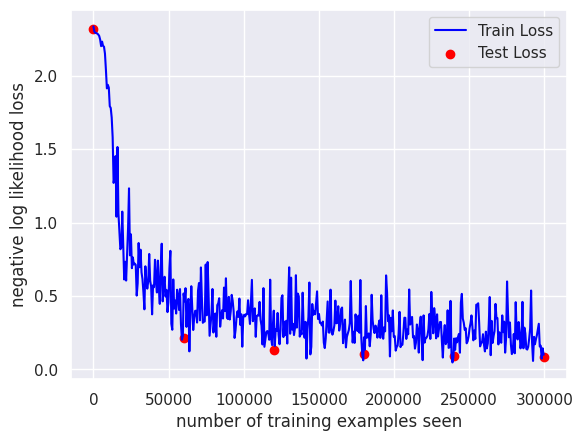

In [ ]:
    baseline_model = base_model()
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, avg_time = train_process(baseline_model, 'baseline', 'baseline_opt')

## Experiment-1:This Assumption suggests that increasing the number of convolution filters in the first layer will lead to learning more features and ultimately improving accuracy, but at the expense of longer training time.

<ipython-input-6-dbbbe7447a6c>:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3265, Accuracy: 480/10000 (5%)

Test set: Avg. loss: 0.2072, Accuracy: 9351/10000 (94%)
Epoch 1 takes: 38.24848484992981s

Test set: Avg. loss: 0.1314, Accuracy: 9580/10000 (96%)
Epoch 2 takes: 72.18015742301941s

Test set: Avg. loss: 0.1025, Accuracy: 9691/10000 (97%)
Epoch 3 takes: 105.70060443878174s

Test set: Avg. loss: 0.0898, Accuracy: 9724/10000 (97%)
Epoch 4 takes: 143.85082840919495s

Test set: Avg. loss: 0.0797, Accuracy: 9755/10000 (98%)
Epoch 5 takes: 177.7933669090271s
Average time per epoch: 107.55495185852051s


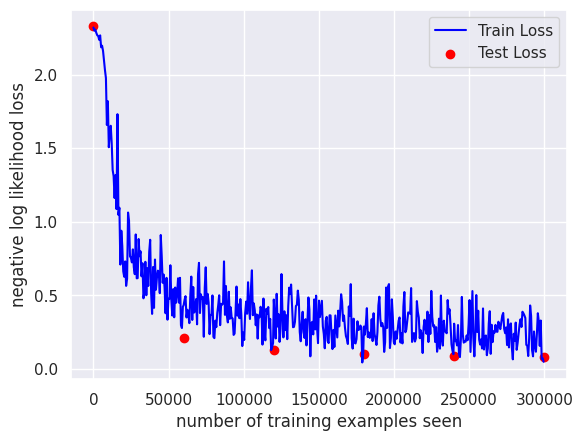


Test set: Avg. loss: 2.3011, Accuracy: 1042/10000 (10%)

Test set: Avg. loss: 0.1952, Accuracy: 9386/10000 (94%)
Epoch 1 takes: 36.25144958496094s

Test set: Avg. loss: 0.1216, Accuracy: 9632/10000 (96%)
Epoch 2 takes: 71.12730264663696s

Test set: Avg. loss: 0.0964, Accuracy: 9697/10000 (97%)
Epoch 3 takes: 105.14796829223633s

Test set: Avg. loss: 0.0827, Accuracy: 9737/10000 (97%)
Epoch 4 takes: 140.25000762939453s

Test set: Avg. loss: 0.0751, Accuracy: 9764/10000 (98%)
Epoch 5 takes: 176.93756914138794s
Average time per epoch: 105.94307036399842s


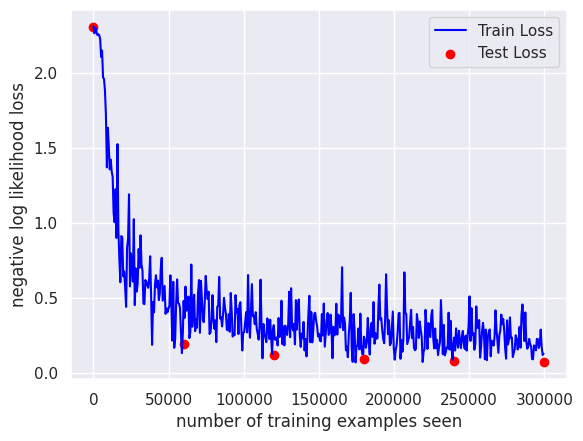


Test set: Avg. loss: 2.3134, Accuracy: 1006/10000 (10%)

Test set: Avg. loss: 0.2464, Accuracy: 9238/10000 (92%)
Epoch 1 takes: 44.02279353141785s

Test set: Avg. loss: 0.1486, Accuracy: 9533/10000 (95%)
Epoch 2 takes: 85.73069143295288s

Test set: Avg. loss: 0.1151, Accuracy: 9642/10000 (96%)
Epoch 3 takes: 134.1549391746521s

Test set: Avg. loss: 0.0981, Accuracy: 9680/10000 (97%)
Epoch 4 takes: 175.7960181236267s

Test set: Avg. loss: 0.0817, Accuracy: 9735/10000 (97%)
Epoch 5 takes: 219.51427745819092s
Average time per epoch: 131.84386944770813s


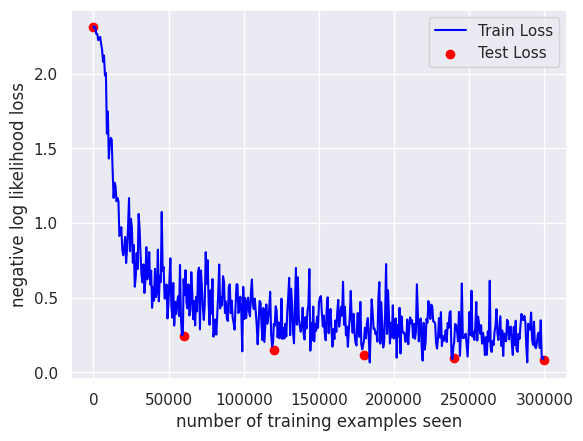


Test set: Avg. loss: 2.3044, Accuracy: 1026/10000 (10%)

Test set: Avg. loss: 0.2329, Accuracy: 9271/10000 (93%)
Epoch 1 takes: 41.53752136230469s

Test set: Avg. loss: 0.1445, Accuracy: 9547/10000 (95%)
Epoch 2 takes: 83.91501879692078s

Test set: Avg. loss: 0.1122, Accuracy: 9659/10000 (97%)
Epoch 3 takes: 129.95214533805847s

Test set: Avg. loss: 0.0951, Accuracy: 9704/10000 (97%)
Epoch 4 takes: 173.50821733474731s

Test set: Avg. loss: 0.0817, Accuracy: 9756/10000 (98%)
Epoch 5 takes: 215.8585877418518s
Average time per epoch: 128.95436449050902s


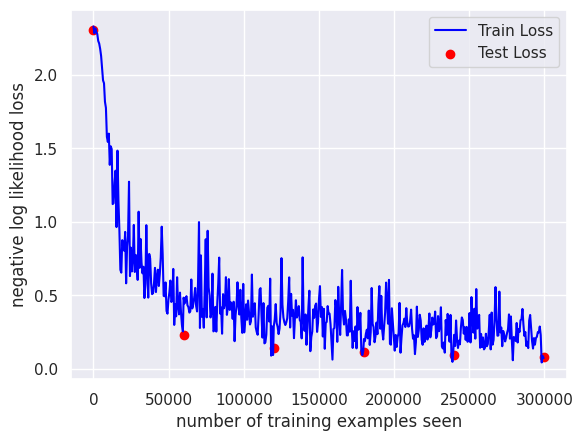


Test set: Avg. loss: 2.3039, Accuracy: 983/10000 (10%)

Test set: Avg. loss: 0.2054, Accuracy: 9375/10000 (94%)
Epoch 1 takes: 42.126200437545776s

Test set: Avg. loss: 0.1233, Accuracy: 9633/10000 (96%)
Epoch 2 takes: 94.0045793056488s

Test set: Avg. loss: 0.1007, Accuracy: 9693/10000 (97%)
Epoch 3 takes: 139.21385717391968s

Test set: Avg. loss: 0.0804, Accuracy: 9743/10000 (97%)
Epoch 4 takes: 181.97594118118286s

Test set: Avg. loss: 0.0722, Accuracy: 9781/10000 (98%)
Epoch 5 takes: 224.38253545761108s
Average time per epoch: 136.34083180427552s


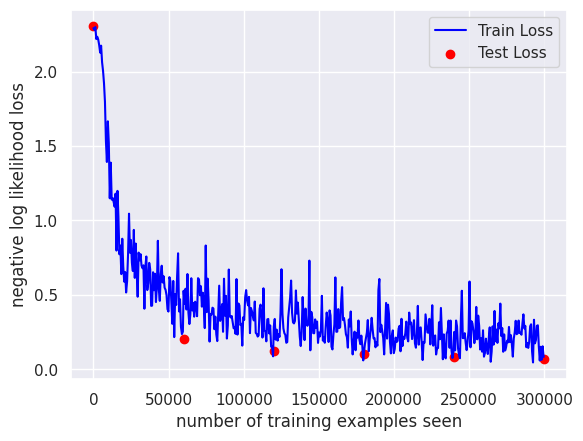


Test set: Avg. loss: 2.3097, Accuracy: 1139/10000 (11%)

Test set: Avg. loss: 0.1939, Accuracy: 9415/10000 (94%)
Epoch 1 takes: 43.55507254600525s

Test set: Avg. loss: 0.1251, Accuracy: 9616/10000 (96%)
Epoch 2 takes: 86.36114287376404s

Test set: Avg. loss: 0.1002, Accuracy: 9666/10000 (97%)
Epoch 3 takes: 130.02240300178528s

Test set: Avg. loss: 0.0835, Accuracy: 9722/10000 (97%)
Epoch 4 takes: 173.13437747955322s

Test set: Avg. loss: 0.0739, Accuracy: 9751/10000 (98%)
Epoch 5 takes: 216.51625394821167s
Average time per epoch: 129.91797904968263s


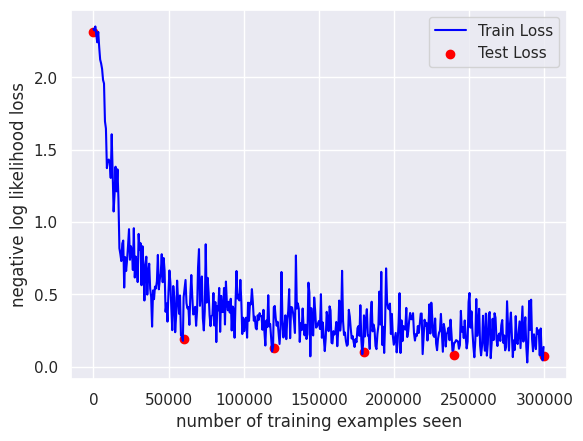

In [ ]:
exp1_models = [base_model(kernel_num=i) for i in range(5, 17, 2)]
exp1_test_losses = []
exp1_accuracies = []
exp1_avg_times = []

for model in exp1_models:
    # Train the model and store the results
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, avg_time = train_process(model, f'exp1_{model.kernel_num}', f'exp1_{model.kernel_num}_opt')
    exp1_test_losses.append(test_losses)
    exp1_accuracies.append(accuracies)
    exp1_avg_times.append(avg_time)

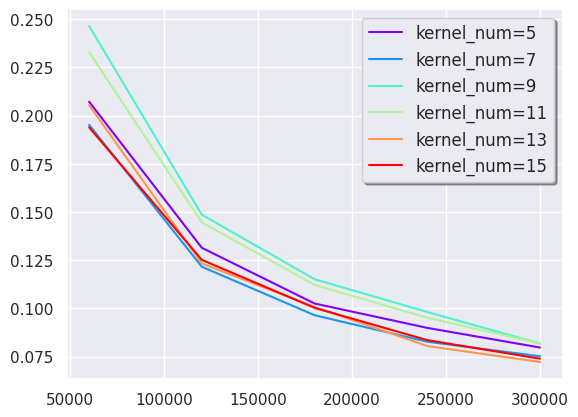

In [ ]:
exp1_list = [i for i in range(5, 17, 2)]
colors = cm.rainbow(np.linspace(0, 1, len(exp1_test_losses)))

fig, ax = plt.subplots()
for loss, color, kernel_num in zip(exp1_test_losses, colors, exp1_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='kernel_num=' + str(kernel_num))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')


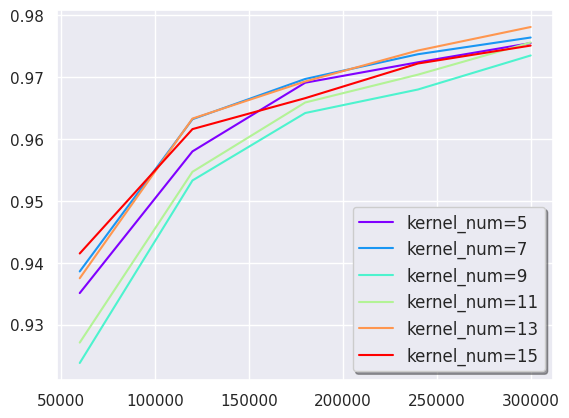

In [ ]:
fig, ax = plt.subplots()
for accuracy, color, kernel_num in zip(exp1_accuracies, colors, exp1_list):
    ax.plot(test_counter[1:], accuracy[1:], color=color, label='kernel_num=' + str(kernel_num))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')


# **Experiment 2: This Assumption suggests that increasing the number of epochs during training may improve the accuracy of the model, but the accuracy may not change significantly once the model has converged.**


<ipython-input-6-dbbbe7447a6c>:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.2144, Accuracy: 9340/10000 (93%)
Epoch 1 takes: 46.12105751037598s

Test set: Avg. loss: 0.1292, Accuracy: 9586/10000 (96%)
Epoch 2 takes: 90.97105622291565s

Test set: Avg. loss: 0.1046, Accuracy: 9675/10000 (97%)
Epoch 3 takes: 146.962012052536s

Test set: Avg. loss: 0.0911, Accuracy: 9729/10000 (97%)
Epoch 4 takes: 196.63747239112854s

Test set: Avg. loss: 0.0823, Accuracy: 9741/10000 (97%)
Epoch 5 takes: 241.60129165649414s

Test set: Avg. loss: 0.0703, Accuracy: 9777/10000 (98%)
Epoch 6 takes: 284.38385462760925s

Test set: Avg. loss: 0.0667, Accuracy: 9788/10000 (98%)
Epoch 7 takes: 336.6287910938263s

Test set: Avg. loss: 0.0601, Accuracy: 9800/10000 (98%)
Epoch 8 takes: 378.2471294403076s
Average time per epoch: 215.1942617893219s


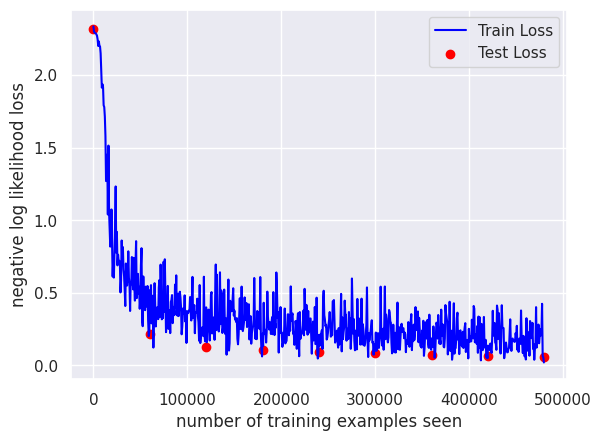

In [ ]:
large_epoch_model = base_model(training_epoch=8)
train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(large_epoch_model, 'exp2', 'exp2')

## **Experiment-3: This Assumption suggests that increasing the size of the pooling layer filters will likely result in lower accuracy, but may lead to faster training times.**

<ipython-input-6-dbbbe7447a6c>:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3110, Accuracy: 1019/10000 (10%)

Test set: Avg. loss: 0.3844, Accuracy: 8997/10000 (90%)
Epoch 1 takes: 47.63676977157593s

Test set: Avg. loss: 0.2192, Accuracy: 9435/10000 (94%)
Epoch 2 takes: 89.66803526878357s

Test set: Avg. loss: 0.1795, Accuracy: 9521/10000 (95%)
Epoch 3 takes: 132.7226209640503s

Test set: Avg. loss: 0.1558, Accuracy: 9605/10000 (96%)
Epoch 4 takes: 175.10721683502197s

Test set: Avg. loss: 0.1353, Accuracy: 9647/10000 (96%)
Epoch 5 takes: 216.54405760765076s
Average time per epoch: 132.33589668273925s


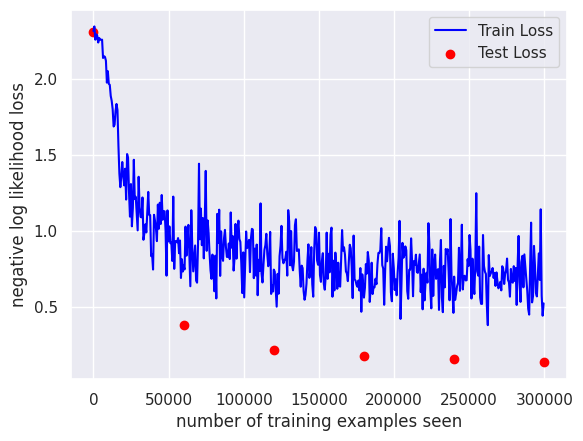


Test set: Avg. loss: 2.3165, Accuracy: 996/10000 (10%)

Test set: Avg. loss: 0.5394, Accuracy: 8702/10000 (87%)
Epoch 1 takes: 35.87716269493103s

Test set: Avg. loss: 0.2691, Accuracy: 9331/10000 (93%)
Epoch 2 takes: 74.84512424468994s

Test set: Avg. loss: 0.1824, Accuracy: 9546/10000 (95%)
Epoch 3 takes: 110.79687476158142s

Test set: Avg. loss: 0.1505, Accuracy: 9608/10000 (96%)
Epoch 4 takes: 146.69382452964783s

Test set: Avg. loss: 0.1324, Accuracy: 9642/10000 (96%)
Epoch 5 takes: 183.84374070167542s
Average time per epoch: 110.41181092262268s


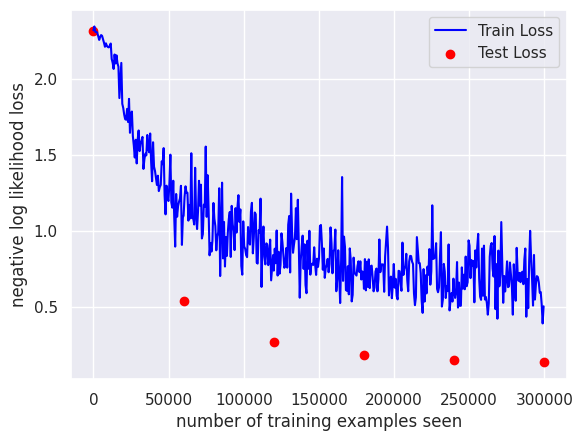


Test set: Avg. loss: 2.3047, Accuracy: 1267/10000 (13%)

Test set: Avg. loss: 0.7888, Accuracy: 7459/10000 (75%)
Epoch 1 takes: 44.10063362121582s

Test set: Avg. loss: 0.5202, Accuracy: 8412/10000 (84%)
Epoch 2 takes: 85.09294009208679s

Test set: Avg. loss: 0.4448, Accuracy: 9029/10000 (90%)
Epoch 3 takes: 119.77022624015808s

Test set: Avg. loss: 0.3684, Accuracy: 9362/10000 (94%)
Epoch 4 takes: 153.30468797683716s

Test set: Avg. loss: 0.3194, Accuracy: 9401/10000 (94%)
Epoch 5 takes: 188.66530966758728s
Average time per epoch: 118.18687801361084s


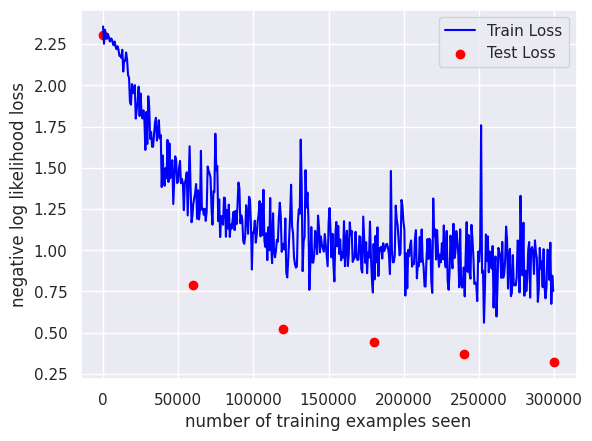

In [ ]:
#experiment settings
pool_sizes = [2, 3, 4]
hidden_nodes = 15

# Create models 
exp3_models = [base_model(pool_size=p, hidden_nodes=hidden_nodes) for p in pool_sizes]

# Train the models
exp3_test_losses = []
exp3_accuracies = []
exp3_avg_time = []

for model, pool_size in zip(exp3_models, pool_sizes):
    exp_name = f'exp3_{pool_size}'
    exp_opt_name = f'exp3_{pool_size}_opt'
    
    # Train the model and record metrics
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, exp_name, exp_opt_name)
    
    # Store the results
    exp3_test_losses.append(test_losses)
    exp3_accuracies.append(accuracies)
    exp3_avg_time.append(average_time)


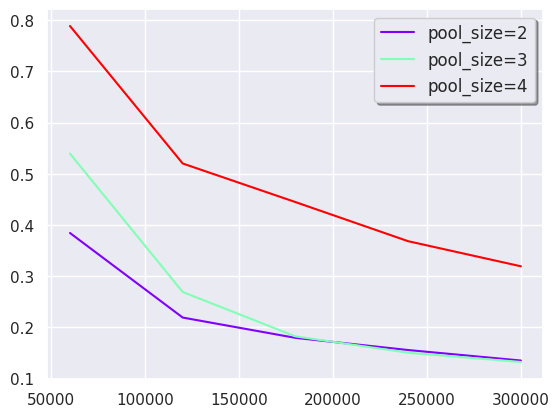

In [ ]:
exp3_list = [i for i in range(2, 5, 1)]
colors = cm.rainbow(np.linspace(0, 1, len(exp3_test_losses)))

fig, ax = plt.subplots()
for loss, color, pool_size in zip(exp3_test_losses, colors, exp3_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='pool_size=' + str(pool_size))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

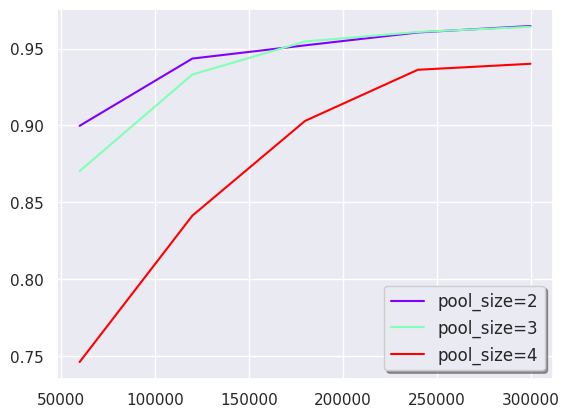

In [ ]:
fig, ax = plt.subplots()
for acc, color, pool_size in zip(exp3_accuracies, colors, exp3_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='pool_size=' + str(pool_size))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

## **Experiment-4: This hypothesis suggests that the tanh and ReLU activation functions are likely to perform well, whereas the softmax and sigmoid activation functions may not perform as well.**

<ipython-input-6-dbbbe7447a6c>:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation_func(F.max_pool2d(self.conv1(x), self.pool_size))
<ipython-input-6-dbbbe7447a6c>:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation_func(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
<ipython-input-6-dbbbe7447a6c>:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation_func(self.fc1(x))
<ipython-input-6-dbbbe7447a6c>:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3095, Accuracy: 958/10000 (10%)

Test set: Avg. loss: 2.3014, Accuracy: 1135/10000 (11%)
Epoch 1 takes: 42.97473859786987s

Test set: Avg. loss: 2.3011, Accuracy: 1135/10000 (11%)
Epoch 2 takes: 86.33191108703613s

Test set: Avg. loss: 2.3011, Accuracy: 1135/10000 (11%)
Epoch 3 takes: 129.7337851524353s

Test set: Avg. loss: 2.3011, Accuracy: 1135/10000 (11%)
Epoch 4 takes: 172.95432424545288s

Test set: Avg. loss: 2.3011, Accuracy: 1135/10000 (11%)
Epoch 5 takes: 215.77520728111267s
Average time per epoch: 129.5542179107666s


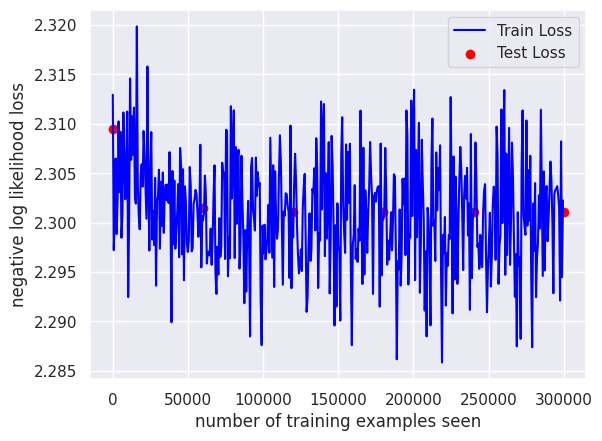


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.2131, Accuracy: 9351/10000 (94%)
Epoch 1 takes: 42.25857734680176s

Test set: Avg. loss: 0.1289, Accuracy: 9607/10000 (96%)
Epoch 2 takes: 84.01490592956543s

Test set: Avg. loss: 0.1054, Accuracy: 9668/10000 (97%)
Epoch 3 takes: 125.94516253471375s

Test set: Avg. loss: 0.0876, Accuracy: 9722/10000 (97%)
Epoch 4 takes: 167.68179273605347s

Test set: Avg. loss: 0.0810, Accuracy: 9734/10000 (97%)
Epoch 5 takes: 209.70191097259521s
Average time per epoch: 125.92061786651611s


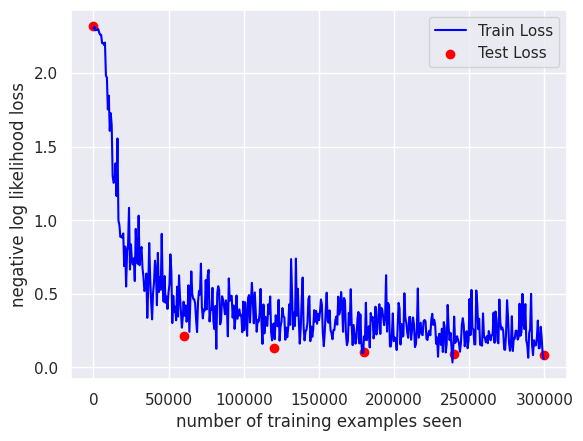


Test set: Avg. loss: 2.3249, Accuracy: 827/10000 (8%)

Test set: Avg. loss: 0.3354, Accuracy: 9043/10000 (90%)
Epoch 1 takes: 42.38585138320923s

Test set: Avg. loss: 0.1922, Accuracy: 9423/10000 (94%)
Epoch 2 takes: 85.17349886894226s

Test set: Avg. loss: 0.1396, Accuracy: 9577/10000 (96%)
Epoch 3 takes: 127.15126371383667s

Test set: Avg. loss: 0.1120, Accuracy: 9663/10000 (97%)
Epoch 4 takes: 169.37729477882385s

Test set: Avg. loss: 0.0957, Accuracy: 9704/10000 (97%)
Epoch 5 takes: 211.50827527046204s
Average time per epoch: 127.11930131912231s


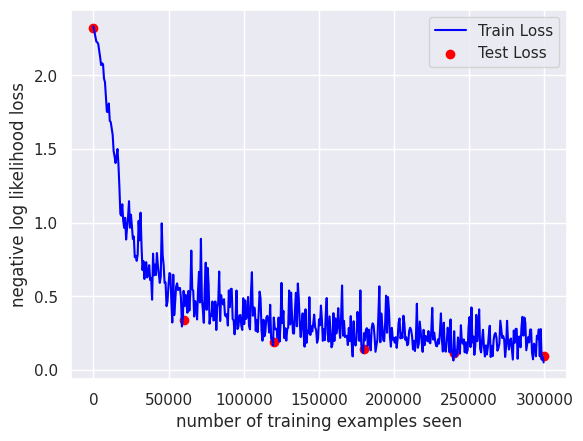


Test set: Avg. loss: 2.3369, Accuracy: 1028/10000 (10%)

Test set: Avg. loss: 2.3008, Accuracy: 1028/10000 (10%)
Epoch 1 takes: 42.16615962982178s

Test set: Avg. loss: 2.3003, Accuracy: 1028/10000 (10%)
Epoch 2 takes: 83.96712851524353s

Test set: Avg. loss: 2.2997, Accuracy: 1028/10000 (10%)
Epoch 3 takes: 126.45592975616455s

Test set: Avg. loss: 2.2990, Accuracy: 1135/10000 (11%)
Epoch 4 takes: 168.44870281219482s

Test set: Avg. loss: 2.2982, Accuracy: 1392/10000 (14%)
Epoch 5 takes: 210.05272769927979s
Average time per epoch: 126.21819987297059s


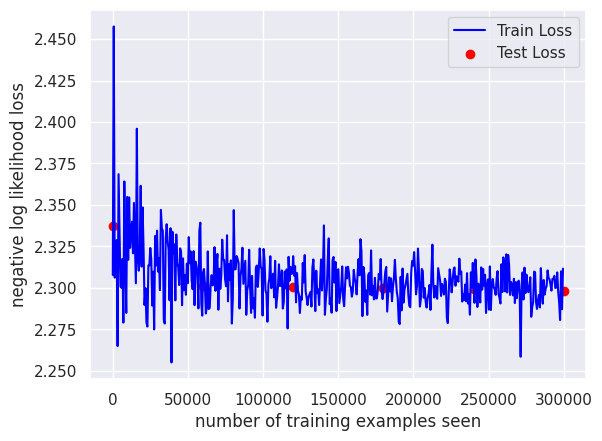

In [ ]:
exp4_models = [base_model(activation_func=f) for f in [F.softmax, F.relu, F.tanh, F.sigmoid]]
exp4_test_losses = []
exp4_accuracies = []
exp4_avg_time = []
for model in exp4_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp4_{model.activation_func.__name__}', f'exp4_{model.activation_func.__name__}_opt')
    exp4_test_losses.append(test_losses)
    exp4_accuracies.append(accuracies)
    exp4_avg_time.append(average_time)


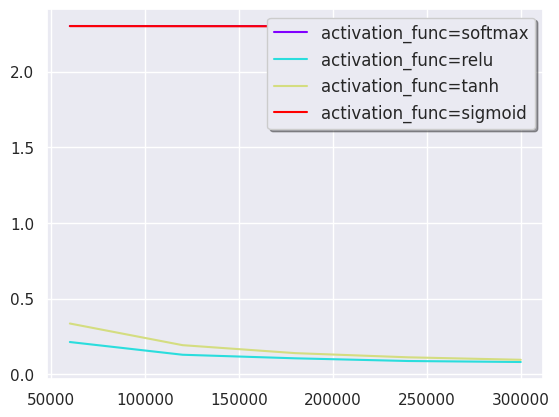

In [ ]:
exp4_list = [F.softmax, F.relu, F.tanh, F.sigmoid]
colors = cm.rainbow(np.linspace(0, 1, len(exp4_test_losses)))

fig, ax = plt.subplots()
for loss, color, f in zip(exp4_test_losses, colors, exp4_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label=f'activation_func={f.__name__}')
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')


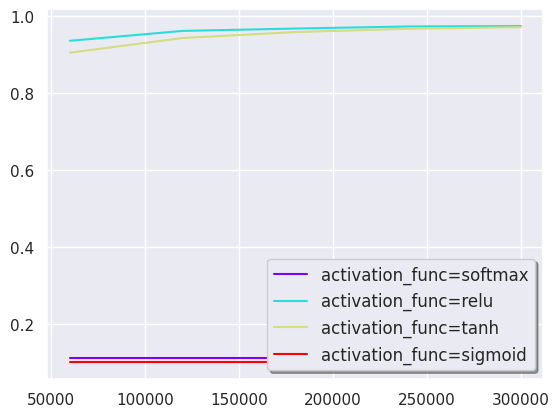

In [ ]:
exp4_list = [F.softmax, F.relu, F.tanh, F.sigmoid]
colors = cm.rainbow(np.linspace(0, 1, len(exp4_accuracies)))

fig, ax = plt.subplots()
for acc, color, func in zip(exp4_accuracies, colors, exp4_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='activation_func=' + func.__name__)
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')
